In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import tensorflow

from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, ReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import shap

In [2]:
RANDOM_SEED = 20210102

np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [4]:
raise Exception('foo')

Exception: foo

In [3]:
train_df = pd.read_csv('data/train.csv')
submission_df = pd.read_csv('data/test.csv')

# Dataset Overview

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [6]:
train_image_df = train_df.copy()
train_image_df.drop(columns=['label'], inplace=True)

train_label_df = train_df['label']

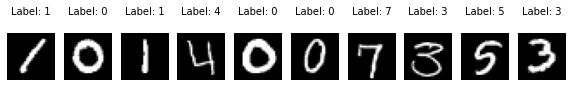

In [7]:
plt.figure(figsize=(10, 10))

for index, (image, label) in enumerate(zip(train_image_df[0:10], train_label_df[0:10])):
    ax = plt.subplot(1, 10, index + 1)
    ax.axis('off')

    plt.imshow(np.reshape(train_image_df.values[index], (28, 28)), cmap='gray')

    plt.title('Label: %i\n' % label, fontsize=10);

## Digit Pixel Distribution

In [8]:
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


Digit pictures consists of **28x28=784** pixels, each pixel can take value from 0 to 255 range (gray-scale).

We can immediately recognize that **some of the pixels always contain zero value** accross all samples (pixel0, pixel1, pixel2, pixel3, pixel4, etc).

## Label Distribution

<AxesSubplot:xlabel='label', ylabel='Count'>

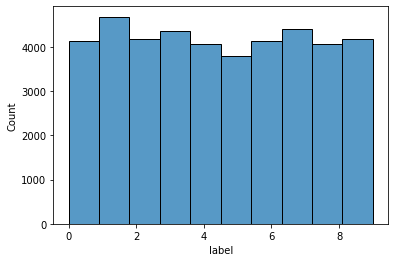

In [9]:
sns.histplot(x=train_label_df, bins=10)

In [10]:
train_label_df.value_counts(), train_label_df.value_counts(normalize=True)

(1    4684
 7    4401
 3    4351
 9    4188
 2    4177
 6    4137
 0    4132
 4    4072
 8    4063
 5    3795
 Name: label, dtype: int64,
 1    0.111524
 7    0.104786
 3    0.103595
 9    0.099714
 2    0.099452
 6    0.098500
 0    0.098381
 4    0.096952
 8    0.096738
 5    0.090357
 Name: label, dtype: float64)

## Test Dataset

In [11]:
train_image_df = train_image_df.astype('float32') / 255.0
submission_df = submission_df.astype('float32') / 255.0

In [12]:
validation_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
test_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_SEED)

for train_idx, val_idx in validation_splitter.split(train_image_df, train_label_df):
    X_train, y_train = train_image_df.iloc[train_idx], train_label_df.iloc[train_idx]
    X_val, y_val = train_image_df.iloc[val_idx], train_label_df.iloc[val_idx]

for train_idx, test_idx in test_splitter.split(X_train, y_train):
    X_test, y_test = X_train.iloc[test_idx], y_train.iloc[test_idx]
    X_train, y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]

<AxesSubplot:xlabel='label', ylabel='Count'>

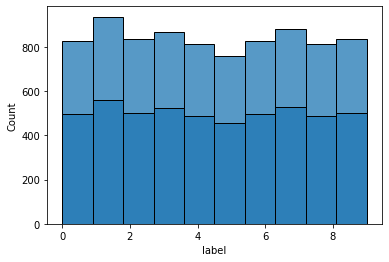

In [13]:
sns.histplot(data=y_val, bins=10)
sns.histplot(data=y_test, bins=10)

# Classification 🧪

## Multilayer Perceptron

In [14]:
NUM_CLASSES = 10

y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

### Architecture

In [15]:
input_layer = Input((784))

#x = Reshape((28, 28, 1))(input_layer)
#x = Conv2D(filters=10, kernel_size=(2, 2), strides=1, padding='same')(x)
#x = Flatten()(x)

x = Dense(200)(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

x = Dense(150)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
re_lu (ReLU)                 (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600   

### Training

In [16]:
optimizer = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

train_history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=32, 
    epochs=50, 
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/50
893/893 [==============================] - 3s 2ms/step - loss: 0.7493 - accuracy: 0.7750 - val_loss: 0.1865 - val_accuracy: 0.9461
Epoch 2/50
893/893 [==============================] - 2s 2ms/step - loss: 0.2328 - accuracy: 0.9307 - val_loss: 0.1343 - val_accuracy: 0.9613
Epoch 3/50
893/893 [==============================] - 2s 2ms/step - loss: 0.1743 - accuracy: 0.9471 - val_loss: 0.1168 - val_accuracy: 0.9652
Epoch 4/50
893/893 [==============================] - 2s 2ms/step - loss: 0.1450 - accuracy: 0.9554 - val_loss: 0.1085 - val_accuracy: 0.9674
Epoch 5/50
893/893 [==============================] - 1s 2ms/step - loss: 0.1196 - accuracy: 0.9627 - val_loss: 0.0995 - val_accuracy: 0.9688
Epoch 6/50
893/893 [==============================] - 2s 2ms/step - loss: 0.1007 - accuracy: 0.9674 - val_loss: 0.0943 - val_accuracy: 0.9719
Epoch 7/50
893/893 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9704 - val_loss: 0.0893 - val_accuracy: 0.9719
Epoch 

Best Validation Loss: 0.0795
Best Validation Accuracy: 0.9789


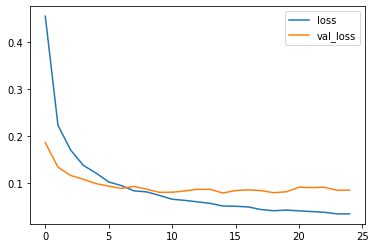

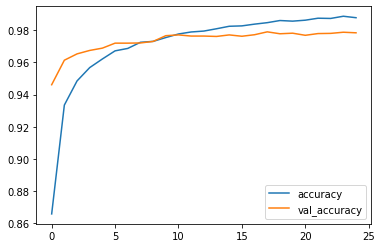

In [17]:
train_history_df = pd.DataFrame(train_history.history)

train_history_df[['loss', 'val_loss']].plot()
train_history_df[['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(train_history_df['val_loss'].min(), 
              train_history_df['val_accuracy'].max()))

### Evaluation

In [18]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [19]:
model.evaluate(X_test, y_test)

## Denses(200, relu) + Dropout(.2) + BatchNorm + Dense(150, relu) + Dropout(.2) + BatchNorm
# Best Validation Loss: 0.0810
# Best Validation Accuracy: 0.9771
# Test Validation Loss: 0.0957236960530281
# Test Accuracy: 0.9724206328392029

## Denses(200) + BatchNorm + LeakyReLu + Dropout(.2) + Dense(150) + BatchNorm + LeakyReLu + Dropout(.2) 
# Best Validation Loss: 0.1024
# Best Validation Accuracy: 0.9723
# Test Validation Loss: 0.11114469170570374
# Test Accuracy: 0.9676587581634521

## Denses(200) + BatchNorm + ReLu + Dropout(.2) + Dense(150) + BatchNorm + ReLu + Dropout(.2) 
# Best Validation Loss: 0.0800
# Best Validation Accuracy: 0.9789
# Test Validation Loss: 0.09856043756008148
# Test Accuracy: 0.9724206328392029

158/158 [==============================] - 0s 664us/step - loss: 0.0931 - accuracy: 0.9738


[0.09312871843576431, 0.973809540271759]

In [20]:
y_test_true = np.argmax(y_test, axis=-1)
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

In [21]:
print('Test Report')
print(classification_report(y_test_true, y_test_pred, digits=4))

Test Report
              precision    recall  f1-score   support

           0     0.9858    0.9778    0.9818       496
           1     0.9806    0.9911    0.9858       562
           2     0.9839    0.9780    0.9810       501
           3     0.9673    0.9636    0.9655       522
           4     0.9639    0.9836    0.9737       489
           5     0.9672    0.9714    0.9693       455
           6     0.9880    0.9920    0.9900       497
           7     0.9648    0.9867    0.9757       528
           8     0.9787    0.9446    0.9613       487
           9     0.9577    0.9463    0.9520       503

    accuracy                         0.9738      5040
   macro avg     0.9738    0.9735    0.9736      5040
weighted avg     0.9738    0.9738    0.9738      5040



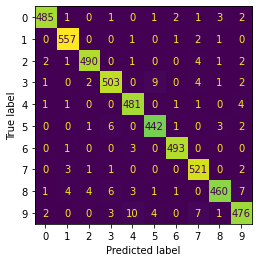

In [22]:
plot_confusion_matrix_by_predictions(y_test_true, y_test_pred)

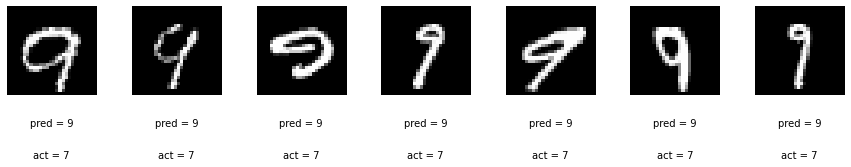

In [23]:
missclass_label_indices = [idx for idx, (label_true, label_pred) in enumerate(zip(y_test_true, y_test_pred)) if label_true == 9 and label_pred == 7]
missclass_len = len(missclass_label_indices)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(missclass_label_indices):    
    ax = fig.add_subplot(1, missclass_len, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(y_test_true[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(y_test_pred[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(np.reshape(X_test.values[idx], (28, 28)), cmap='gray')

In [28]:
# https://github.com/slundberg/shap/pull/1483
#misclass_background = X_train.iloc[missclass_label_indices]
#explainer = shap.DeepExplainer(model, misclass_background)
#shap_values = explainer.shap_values(X_train[1:5])

#shap.image_plot(shap_values, -X_train[1:5])


### Submission

In [70]:
y_submission = np.argmax(model.predict(submission_df), axis=-1)

submission_label_df = pd.DataFrame({
    'ImageId': list(range(1, len(y_submission) + 1)), 
    'Label': y_submission
})

submission_label_df.to_csv('data/mlp_submission.csv', index=False, header=True)